In [1]:
import jax
from jax import random
from jax import numpy as jnp

from localdynamics import derivative, local_dynamics
from localdynamics.plotting import plot

from matplotlib import pyplot as plt
import matplotlib

import numpy as np

jax.config.update('jax_platforms', 'cpu')
jax.config.update("jax_default_device", jax.devices('cpu')[0])

# Generate dummy data

In [2]:
def rational_quadratic(x, s=1.0, alpha=1.0, l=1.0):

    return s*(1+x**2/(2*alpha*l**2))**-alpha


def generate_covariance(ts, kernel):

    C = kernel(ts[:,jnp.newaxis] - ts[jnp.newaxis])

    return C


def gaussian_process(key, time_dim, neuron_dim, trial_dim=1, kernel=rational_quadratic, cholesky_epsilon=10**-5, t_max=10, **kwargs):

    ts = jnp.linspace(0, t_max, time_dim)

    C = generate_covariance(ts, kernel)

    L = jnp.linalg.cholesky(C+cholesky_epsilon*jnp.eye(time_dim))

    latent_gaussians = random.normal(key=key, shape=(trial_dim, time_dim, neuron_dim))

    gp = jnp.einsum('ti,kin->ktn', L, latent_gaussians)

    return ts, gp, C, L

In [3]:
def cylinder_data(key, time_dim):
    
    key, subkey = random.split(key)
    _, gp, _, _ = gaussian_process(subkey, time_dim, 2, 1, t_max=100)
    
    gp = gp[0] * 3
    
    key, subkey = random.split(key)
    gp = gp + random.uniform(subkey, [1, gp.shape[-1]], minval=0, maxval=jnp.pi*2)
    
    xs = jnp.stack([jnp.cos(gp[..., 0]), jnp.sin(gp[..., 0])], axis=-1)
    zs = gp[..., 1:]*2
        
    data = jnp.concatenate([xs, zs], axis=-1)
    
    data = data/jnp.std(data, axis=0, keepdims=True)

    return data

def sphere_data(key, time_dim):
    
    key, subkey = random.split(key)
    _, gp, _, _ = gaussian_process(subkey, time_dim, 3, 1, t_max=200)
    
    gp = gp[0]
    
    data = gp/jnp.linalg.norm(gp, axis=-1, keepdims=True)
    
    data = data/jnp.std(gp, axis=0, keepdims=True)
    
    return data


def cat(*args): return jnp.concatenate(args, axis=-1)

def zero_data(key, time_dim):
    
    return jnp.zeros((time_dim, 1))

def plane_data(key, time_dim, neuron_dim):
    
    _, gp, _, _ = gaussian_process(key, time_dim, neuron_dim, 1, t_max=100)

    return gp[0]

def project(key, data, neuron_dim):
    
    key, subkey = random.split(key)
    U , _, _ = jnp.linalg.svd(random.normal(subkey, (neuron_dim, neuron_dim)), full_matrices=False)
    data_projected = data @ U[:data.shape[-1]]
    
    return data_projected

def gaussian_noise(key, data, noise_coefficient=0.1):
        
    return data/(data.std(axis=0, keepdims=True) + 10**-8) + noise_coefficient*random.normal(key=key, shape=data.shape)#/jnp.sqrt(data.shape[-1])
    
def gp_noise(key, data, noise_coefficient=1.0):
    
    _, gp, _, _ = gaussian_process(key, time_dim, data.shape[-1], 1, t_max=100)
        
    return data/(data.std(axis=0, keepdims=True) + 10**-8) + noise_coefficient*gp[0]/jnp.std(gp[0], axis=0, keepdims=True)#/jnp.sqrt(data.shape[-1])


def pack(dataset_name, data_matrix, ts, dim):
    
    return {'name': dataset_name, 'latent': data_matrix, 'ts':ts, 'dim':dim}


time_dim, neuron_dim = 1000, 100
key = random.key(1)

#dataset_names = ['2D Plane', '2D Plane+Noise', '2D Plane+GP Noise', '2D Cylinder', f'{neuron_dim}D Gaussian', f'{neuron_dim}D Process']
#xs = [plannar_data(key, time_dim, neuron_dim), plannar_data(key, time_dim, neuron_dim, 0.1), plannar_data(key, time_dim, neuron_dim, 0.0, 0.1), cylinder_data(key, time_dim, neuron_dim), gaussian_data(key, time_dim, neuron_dim), gp_data(key, time_dim, neuron_dim)]
ts = jnp.linspace(0, 1, time_dim+1)[:, jnp.newaxis]

key, subkey = random.split(key)
datasets = [pack('Plane', plane_data(key, time_dim, 2), ts, 2),
            pack('Cylinder', cylinder_data(key, time_dim), ts, 2),
            pack('Sphere', sphere_data(key, time_dim), ts, 2),
            pack('Plane', plane_data(key, time_dim, 4), ts, 4),
            pack('Sph x Cyl', cat(sphere_data(key, time_dim), cylinder_data(subkey, time_dim)), ts, 4),
            pack(f'Gaussian', gaussian_noise(key, jnp.zeros((time_dim, neuron_dim))), ts, neuron_dim),
            pack(f'GP', gp_noise(key, jnp.zeros((time_dim, neuron_dim))), ts, neuron_dim)
            ]

key, subkey = random.split(key)
for d in datasets:
    d['xs'] = project(subkey, d['latent'], neuron_dim)

key, subkey = random.split(key)
gaussian_noise_datasets = [{'name': d['name']+' + Gaussian Noise', 'latent':d['latent'], 'ts':d['ts'], 'xs': gaussian_noise(subkey, d['xs']), 'dim':d['dim']} for d in datasets]
    
key, subkey = random.split(key)
gp_noise_datasets = [{'name': d['name']+' + GP Noise', 'latent':d['latent'], 'ts':d['ts'], 'xs': gp_noise(subkey, d['xs']), 'dim':d['dim']} for d in datasets]

#datasets = datasets + gaussian_noise_datasets + gp_noise_datasets

datasets = gp_noise_datasets

for d in datasets:
    print(f'{d['name']}, Latent:{d['latent'].shape}, Data:{d['xs'].shape}')

Plane + GP Noise, Latent:(1000, 2), Data:(1000, 100)
Cylinder + GP Noise, Latent:(1000, 3), Data:(1000, 100)
Sphere + GP Noise, Latent:(1000, 3), Data:(1000, 100)
Plane + GP Noise, Latent:(1000, 4), Data:(1000, 100)
Sph x Cyl + GP Noise, Latent:(1000, 6), Data:(1000, 100)
Gaussian + GP Noise, Latent:(1000, 100), Data:(1000, 100)
GP + GP Noise, Latent:(1000, 100), Data:(1000, 100)


# Compute the singular values

The analysis depends on three key hyperparameters: the number of neighboring points, whether we rescale the dynamics to unit length, and whether if scale the dynamics by their distance to the central point.

In [4]:
nb_neighbors = np.logspace(1, 8, 8, 2**8, base=2, dtype=int)
nb_neighbors = np.linspace(1, 51, 51, dtype=int)

print(f'Number of neighbors: {nb_neighbors}')

for d in datasets:
    print(d['name'])
    d['dxs_dts'] = derivative(d['ts'][1:]-d['ts'][:-1], d['xs'], accuracy=2)
    d['local_dxs_dts'] = local_dynamics(d['xs'], d['dxs_dts'], number_of_neighbors=np.max(nb_neighbors), unit_length=True, distance_scaling=None)
    d['local_xs'] = local_dynamics(d['xs'], d['xs'], number_of_neighbors=np.max(nb_neighbors), unit_length=False, distance_scaling=None) - d['xs'][..., jnp.newaxis, :]
    d['sv_local_dxs_dts'] = jnp.stack([jnp.concatenate([jnp.linalg.svd(d['local_dxs_dts'][..., :k, :], full_matrices=False, compute_uv=False), 
                                                        jnp.full((d['local_dxs_dts'].shape[0], np.max(nb_neighbors) - min(k, d['local_dxs_dts'].shape[2]),), jnp.nan)], axis=-1) for k in nb_neighbors])

print()

Number of neighbors: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51]
Plane + GP Noise
Cylinder + GP Noise
Sphere + GP Noise
Plane + GP Noise
Sph x Cyl + GP Noise
Gaussian + GP Noise
GP + GP Noise



# Plotting

In [5]:
# data_set, nb_neighbors, point, sv
def plot_sv_barcode(ax, nb_neighbors, sv, dim=None, cmap1=matplotlib.colormaps['Blues'], cmap2=matplotlib.colormaps['Greens_r']):
            
    sv = sv / jnp.nanmax(sv, axis=-1, keepdims=True)
    #sv = sv/jnp.nanmax(sv, axis=(0,))
    #sv = jnp.nanquantile(sv, 0.99, axis=-2)
    sv = jnp.nanmax(sv, axis=-2)
    sv = sv.T
    
    dim = sv.shape[-1] if dim is None else dim
    
    for si, s in enumerate(sv):
        
        color = cmap1((si+1)/dim) if si < dim else cmap2((si+1)/(len(sv) - dim))
        
        ax.plot(nb_neighbors, s, '-o', color=color if si != 0 else (0.2, 0.2, 0.2), zorder=4)     
    
    ax.set_xlabel('# Neighbors'), ax.set_ylabel('Local Dyn. SV')

            
def plot_srank(ax, nb_neighbors, sv, dim):
    
    sv = sv / jnp.nanmax(sv, axis=-1, keepdims=True)
    #sv = sv/jnp.nanmax(sv, axis=(0,))
    sv = jnp.nanquantile(sv, 1.0, axis=-2)
    sv_ = jnp.nansum(sv**4, axis=-1)
    
    #sv  = jnp.exp(-jnp.nansum(jnp.log(sv/sv_[..., jnp.newaxis])*sv/sv_[..., jnp.newaxis], axis=-1))
    sv = sv_
    #sv = sv[1:]
    #sv = jnp.nanargmax(jnp.abs(jnp.arange(sv.shape[-1])[jnp.newaxis]/(sv.shape[-1] - 1) + (sv - jnp.nanmin(sv, axis=-1, keepdims=True))/(jnp.nanmax(sv, axis=-1, keepdims=True) - jnp.nanmin(sv, axis=-1, keepdims=True)) - 1)-1, axis=-1)/jnp.sqrt(2)
    
    #sv = sv[1:] - sv[:-1]
    
    ax.plot(nb_neighbors, sv, '-o', color='red')
    
    ax.axhline(dim, linestyle='--', label='True dim')
    
    ax.legend()
    
    ax.set_xlabel('# Neighbors'), ax.set_ylabel('sRank')


def plot_latent(ax, latent):
    
    ax.plot(*latent[:, :3].T, color=(0.95, 0.8, 0.2))

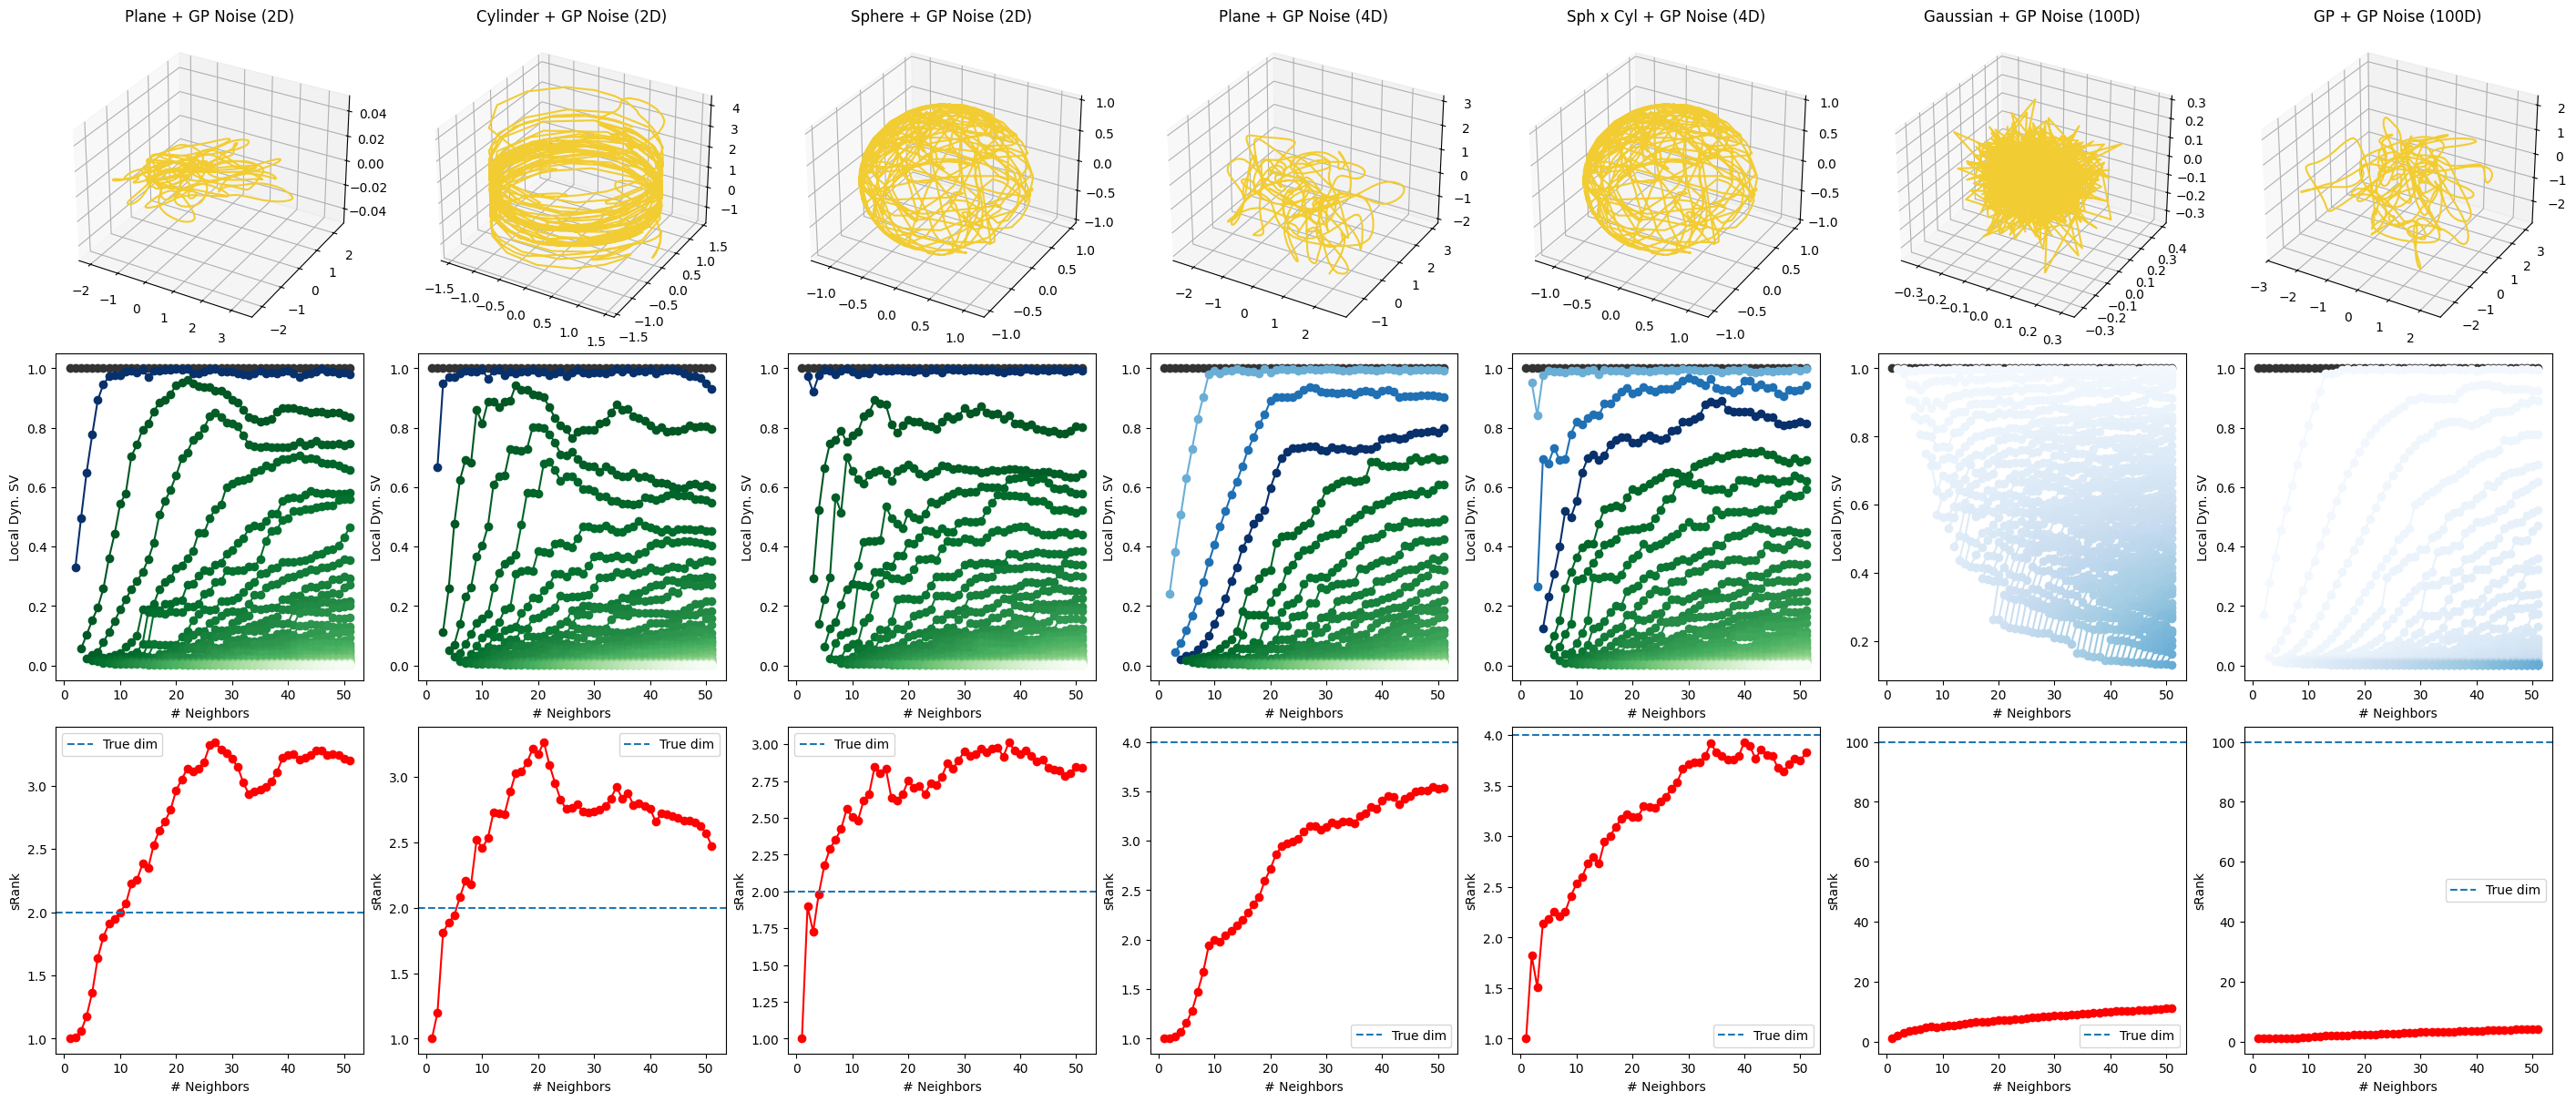

In [6]:
fig, axs = plot.get_axes_grid(cols=len(datasets), rows=3, rows_3d=[0], dpi=100)

for d, ax in zip(datasets, axs):
    ax[0].set_title(f'{d['name']} ({d['dim']}D)')
    plot_latent(ax[0], d['latent'])
    plot_sv_barcode(ax[1], nb_neighbors, d['sv_local_dxs_dts'], d['dim'])
    plot_srank(ax[2], nb_neighbors, d['sv_local_dxs_dts'], d['dim'])
    
plt.show()